In [1]:
import pickle
import glob
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## Loading the data from evaluation

The runs have each had their own numeric indicator, to make sense of them, I map them to the names used in the paper. The AccFl-batched approaches were run by first doing an initial round, after which the accfl learning started. The accfl learning starts at epoch zero, therefore we need to offset the rounds by one and add the results of the initial round (round=0) manually.

In [2]:
mapping = {'10b': '2-2-SUM', '12': '2-2-MAX', '11n': '2-2-AVG', '8':'2-2-RND', '14':'8-2-MAX', '16c': '8-2-RND', '99': '2-AccFL-Batch-SUM', '91': "2-AccFL-Batch-MAX", '81': "8-AccFL-Batch-SUM", 'CFed': "2-AccFL-FedAvg"}
offset_one_rounds = ['99', '91', '81', 'CFed'] 
# Initial round checkpoint files are: 
# chainmaxcheckpoint.pt, chaincheckpoint.pt, test8feddd.pt

### This can be skipped, DF is provided.

I evaluate all runs using evaluate.py (in public git repo) and store the results in .pickle files. Makes it so I can run the evaluation and analysis on different computers easily. So now load selected variables and offset the rounds by one.

In [3]:
pickle_files = glob.glob('./evals/fed-*.pickle')
results = {x: dict() for x in mapping.keys()}
results_classes = []
for pickle_file in pickle_files:
    result_id = Path(pickle_file).stem
    result_run = result_id.split('-')[1]
    if result_run not in mapping.keys():
        continue
    result_iteration = result_id.split('-')[2]
    if result_run in offset_one_rounds:
        result_iteration=(int(result_iteration)+1)
    with open(pickle_file, 'rb') as f:
        result = pickle.load(f)
        results[result_run][result_iteration] =  {'mp': result['mp'], 'mr':  result['mr'], 'map50': result['map50'], 'map':  result['map'], 'losses':  result['losses']}


Add the initial rounds: (I analyzed these manually, see screenshot:)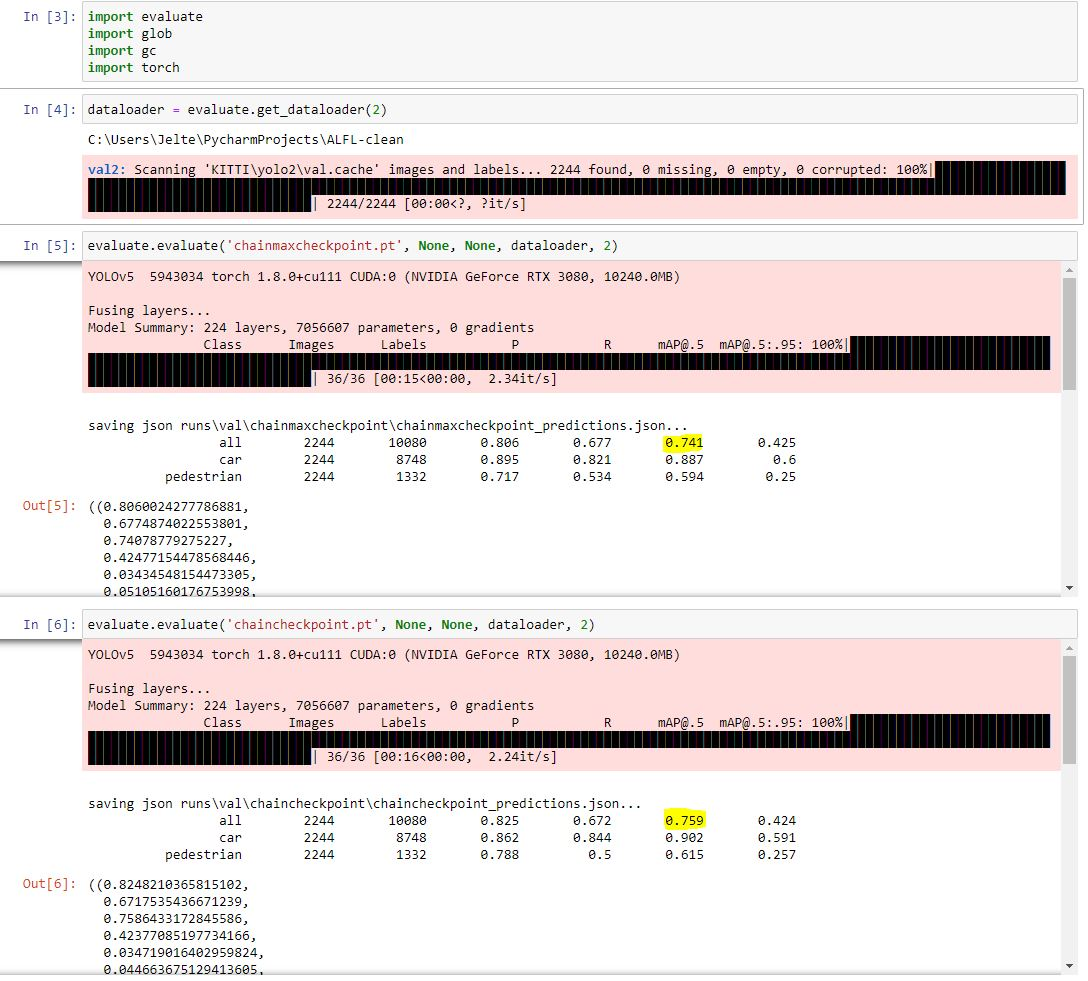 

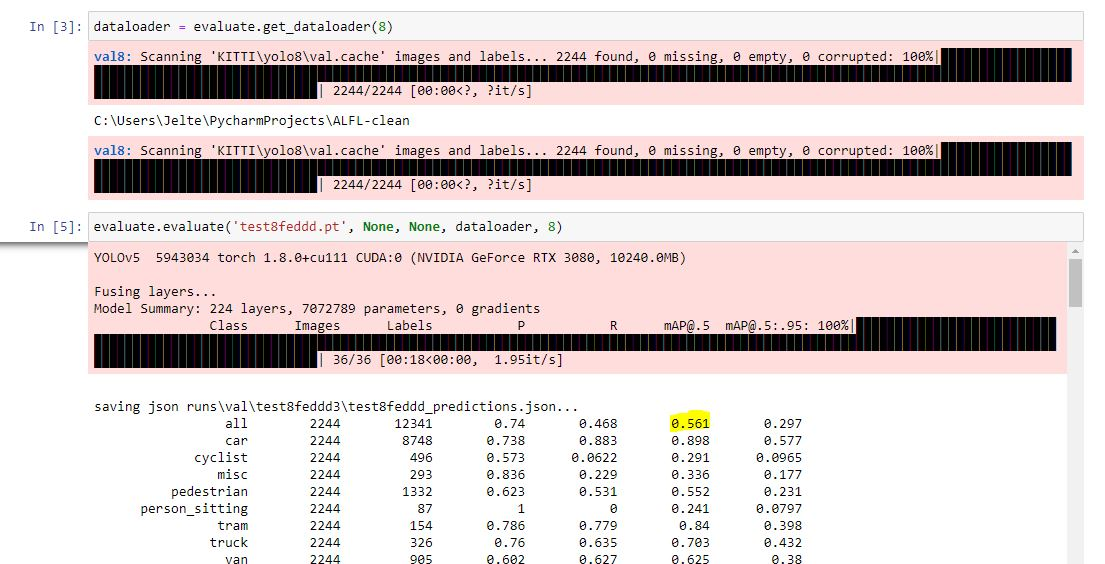

In [4]:
results['99']['0'] = {'mp': 0.825, 'mr':  0.672, 'map50':  0.759, 'map':  0.424, 'losses': []}
results['91']['0'] = {'mp': 0.806, 'mr':  0.677, 'map50':  0.741, 'map':  0.425, 'losses': []}
results['81']['0'] = {'mp': 0.74, 'mr':  0.468, 'map50':  0.561, 'map':  0.297, 'losses': []}
results['CFed']['0'] = {'mp': 0.825, 'mr':  0.672, 'map50':  0.759, 'map':  0.424, 'losses': []}

Now turn it into a pandas dataframe

In [5]:
frames = [pd.DataFrame.from_dict(results[x], orient='index') for x in results] 
df_frames = pd.concat(frames, keys=[x for x in results])
df_frames.reset_index(inplace=True)  
df_frames = df_frames.rename(columns={'level_0': 'run', 'level_1': 'round'})
df_frames["round"] = pd.to_numeric(df_frames["round"])
df_frames.sort_values(['run', 'round'], ascending = (True, True))
df_frames[['val_box_loss','val_obj_loss', 'val_cls_loss']] = pd.DataFrame(df_frames.losses.tolist(), index= df_frames.index)
df_frames['name'] = df_frames.apply (lambda row: mapping.get(row['run']), axis=1)
df_frames.loc[(df_frames['round'] == 200)]

,run,round,mp,mr,map50,map,losses,val_box_loss,val_obj_loss,val_cls_loss,name
114,10b,200,0.788287,0.636870,0.687648,0.362846,"[0.038355059921741486, 0.050650738179683685, 0...",0.038355,0.050651,0.001456,2-2-SUM
315,12,200,0.813522,0.673519,0.747228,0.401923,"[0.03673669695854187, 0.04769470915198326, 0.0...",0.036737,0.047695,0.001084,2-2-MAX
516,11n,200,0.819420,0.656451,0.725611,0.375529,"[0.039839837700128555, 0.05291461944580078, 0....",0.039840,0.052915,0.001410,2-2-AVG
717,8,200,0.827572,0.647443,0.730057,0.397257,"[0.03713254630565643, 0.048718299716711044, 0....",0.037133,0.048718,0.001141,2-2-RND
918,14,200,0.599186,0.582367,0.577404,0.285316,"[0.039290353655815125, 0.05696219205856323, 0....",0.039290,0.056962,0.010041,8-2-MAX
1119,16c,200,0.573859,0.504229,0.529132,0.263552,"[0.041488997638225555, 0.06148204579949379, 0....",0.041489,0.061482,0.011427,8-2-RND
1316,99,200,0.908434,0.778646,0.852298,0.523640,"[0.028674999251961708, 0.03865431249141693, 0....",0.028675,0.038654,0.000759,2-AccFL-Batch-SUM
1516,91,200,0.901168,0.816619,0.870219,0.543497,"[0.027875324711203575, 0.03841536119580269, 0....",0.027875,0.038415,0.000691,2-AccFL-Batch-MAX
1717,81,200,0.890352,0.754422,0.821465,0.518533,"[0.0316801480948925, 0.04934133589267731, 0.00...",0.031680,0.049341,0.005580,8-AccFL-Batch-SUM


A couple of runs, such as AccFL-MultiEpoch have an initial round which comprises multiple clients. As the federated checkpoint does not have much granularity (i.e. mAP progression between clients), we load these ones seperately with an added 'client' column.

In [6]:
pickle_files = glob.glob('./evals/0106*.pickle') +  glob.glob('./evals/run-15-*.pickle')
results_client = {}
for pickle_file in pickle_files:
    result_id = Path(pickle_file).stem
    if '0106' in result_id: 
        run = '2-AccFL-MultiEpoch'
        result_iteration = result_id.split('kitti')[1][1]
        client = result_id.split('kitti')[1][0]
    elif 'run-15' in result_id:
        run = '8-AccFL-MultiEpoch'
        result_iteration = result_id.split('-')[3]
        client = result_id.split('-')[2]
    with open(pickle_file, 'rb') as f:
        result = pickle.load(f)
        if run not in results_client:
            results_client[run] = dict()
        if result_iteration not in results_client[run]:
            results_client[run][result_iteration] = dict()
        results_client[run][result_iteration][client] =  {'mp': result['mp'], 'mr':  result['mr'], 'map50':  result['map50'], 'map':  result['map'], 'losses':  result['losses']}


And convert to Dataframe

In [7]:
df_temp = pd.DataFrame.from_dict({(i,j, z): results_client[i][j][z] 
                           for i in results_client.keys() 
                           for j in results_client[i].keys()
                           for z in results_client[i][j].keys()},
                       orient='index')
df_temp.reset_index(inplace=True)
df_temp = df_temp.rename(columns={'level_0': 'run', 'level_1': 'round', 'level_2': 'client'})
df_temp["client"] = pd.to_numeric(df_temp["client"])
df_temp["round"] = pd.to_numeric(df_temp["round"])
df_temp['name'] = df_temp['run']
df_temp[['val_box_loss','val_obj_loss', 'val_cls_loss']] = pd.DataFrame(df_temp.losses.tolist(), index= df_temp.index)
df_temp = df_temp.sort_values(['run', 'round', 'client'], ascending = (True, True, True))
df_temp

,run,round,client,mp,mr,map50,map,losses,name,val_box_loss,val_obj_loss,val_cls_loss
0,2-AccFL-MultiEpoch,0,0,0.690002,0.523710,0.567205,0.289203,"[0.04392663389444351, 0.05559306591749191, 0.0...",2-AccFL-MultiEpoch,0.043927,0.055593,0.002800
1,2-AccFL-MultiEpoch,0,1,0.755064,0.551626,0.605168,0.323497,"[0.04113510251045227, 0.05519235506653786, 0.0...",2-AccFL-MultiEpoch,0.041135,0.055192,0.002472
2,2-AccFL-MultiEpoch,0,2,0.756890,0.589625,0.643348,0.350642,"[0.0393984355032444, 0.053529009222984314, 0.0...",2-AccFL-MultiEpoch,0.039398,0.053529,0.001790
3,2-AccFL-MultiEpoch,0,3,0.776178,0.624192,0.692359,0.373958,"[0.03753930330276489, 0.04715919867157936, 0.0...",2-AccFL-MultiEpoch,0.037539,0.047159,0.001347
4,2-AccFL-MultiEpoch,0,4,0.827381,0.642201,0.716241,0.401134,"[0.036001935601234436, 0.05090545117855072, 0....",2-AccFL-MultiEpoch,0.036002,0.050905,0.001353
...,...,...,...,...,...,...,...,...,...,...,...,...
103,8-AccFL-MultiEpoch,5,4,0.787606,0.537941,0.607792,0.327245,"[0.0417223758995533, 0.04608505219221115, 0.00...",8-AccFL-MultiEpoch,0.041722,0.046085,0.008801
104,8-AccFL-MultiEpoch,5,5,0.790278,0.533148,0.614301,0.329805,"[0.04178428277373314, 0.04625223949551582, 0.0...",8-AccFL-MultiEpoch,0.041784,0.046252,0.008780
105,8-AccFL-MultiEpoch,5,6,0.791800,0.532618,0.619745,0.333474,"[0.04173526167869568, 0.04618019610643387, 0.0...",8-AccFL-MultiEpoch,0.041735,0.046180,0.008732
106,8-AccFL-MultiEpoch,5,7,0.775059,0.547905,0.616335,0.330388,"[0.04175444692373276, 0.04610852524638176, 0.0...",8-AccFL-MultiEpoch,0.041754,0.046109,0.008691


Add to previous dataframe.

In [8]:
df = pd.concat([df_temp, df_frames])

Now there's only one issue: for df_temp we would like to draw graphs using the client variable as x-axis, whereas for df_frames we would like to draw graphs with round as the x-axis. So we create a new column x-axis which is conditional on the run type.

In [9]:
df['x-axis'] = df.apply(lambda row: row[1]+(row[2]/9) if row[8] in ["2-AccFL-MultiEpoch", "8-AccFL-MultiEpoch"] else row[1], axis=1)


In [10]:
df.groupby('name').max('x-axis')['map50']

name
2-2-AVG               0.727775
2-2-MAX               0.750827
2-2-RND               0.739384
2-2-SUM               0.690372
2-AccFL-Batch-MAX     0.873435
2-AccFL-Batch-SUM     0.854983
2-AccFL-FedAvg        0.781102
2-AccFL-MultiEpoch    0.787597
8-2-MAX               0.577404
8-2-RND               0.533471
8-AccFL-Batch-SUM     0.824073
8-AccFL-MultiEpoch    0.619745
Name: map50, dtype: float64

With the dataframe complete, we export it for future use. It is attached to this notebook so the large amount of pickle files do not have to be shared.

In [11]:
df.to_pickle('analysis.dump')

## Creating the Graphs

In [12]:
traditional_approaches = ['2-2-SUM','2-2-MAX','2-2-AVG','2-2-RND', '8-2-MAX', '8-2-RND']
accfl_approaches = ['2-AccFL-Batch-MAX', '2-AccFL-Batch-SUM', '2-AccFL-FedAvg', '2-AccFL-MultiEpoch', '8-AccFL-Batch-SUM', '8-AccFL-MultiEpoch']

In [13]:
df = pd.read_pickle('analysis.dump')

<ipython-input-14-108344db3ec2>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figures/1.eps', dpi=1600, figsize=(2,5), format='eps')


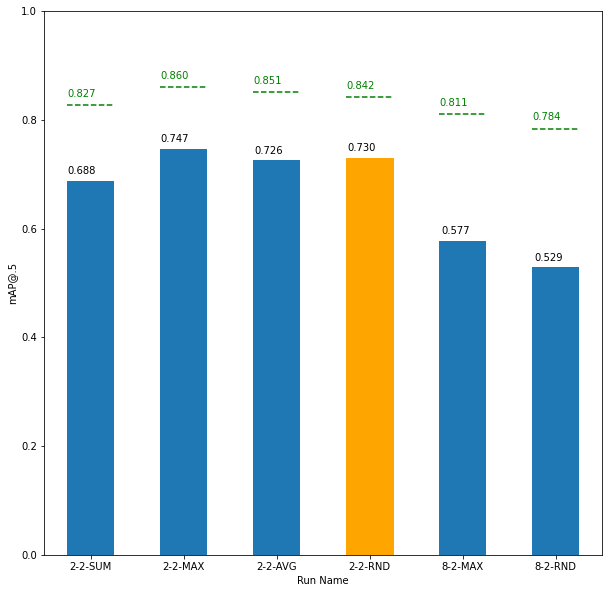

In [14]:
# OLD GRAPH, NOT USED IN PAPER ANYMORE
fig, ax = plt.subplots()
barlist = df.loc[(df['round'] == 200) & df['name'].isin(traditional_approaches)].plot.bar(x='name', y='map50', rot=0, ax=ax, ylabel="mAP@.5", xlabel="Run Name", figsize=(10,10))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() * 1.005, p.get_height() +0.012))
ax.get_children()[3].set_color('orange')

centralized_results = {'2-2-SUM': 0.827, '2-2-AVG': 0.851, '2-2-MAX': 0.86, '2-2-RND': 0.842, '8-2-MAX': 0.811, '8-2-RND': 0.784}
count = 0
for x in df.loc[(df['round'] == 200) & df['name'].isin(traditional_approaches)]['name']:
    ax.annotate("%.3f" % centralized_results[x], (count-0.25, centralized_results[x] +0.015),color="green")
    plt.hlines(centralized_results[x],xmin=count-0.25,xmax=count+.25,colors="green", linestyles="dashed")
    count += 1

ax.set_ylim(0, 1.0)
ax.get_legend().remove()
plt.savefig('./figures/1.eps', dpi=1600, figsize=(2,5), format='eps')

<ipython-input-15-fb42d39e0213>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figures/3.eps', dpi=1600, format='eps', figsize=(6, 5))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


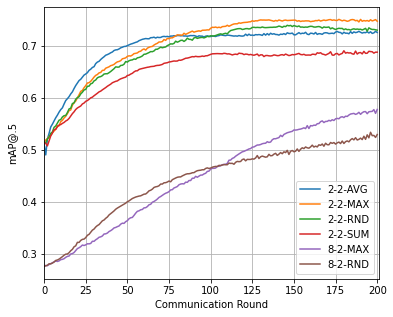

In [15]:
from matplotlib.ticker import FormatStrFormatter
df_map = df
df_map = df_map.set_index('round')
df_map = df_map.sort_index(ascending=True)
fig, ax = plt.subplots()
plots = df_map.loc[df_map['name'].isin(traditional_approaches)].groupby('name')['map50'].plot(xlabel='Communication Round', ylabel='mAP@.5', ax=ax, legend=True, figsize=(6, 5))
ax.legend()
ax.grid(True)
ax.set_xlim(0,201)
plt.savefig('./figures/3.eps', dpi=1600, format='eps', figsize=(6, 5))

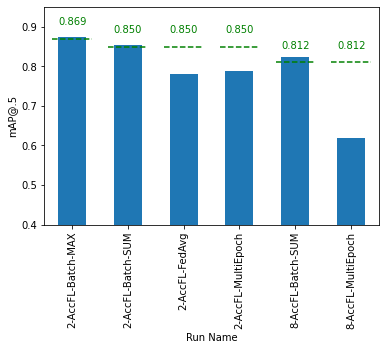

In [16]:
# OLD GRAPH, NOT USED IN PAPER ANYMORE
ax = df.loc[df['name'].isin(accfl_approaches)].groupby('name').max('x-axis')['map50'].plot.bar()
centralized_results = {'2-AccFL-Batch-MAX': 0.869, '2-AccFL-Batch-SUM': 0.85, '2-AccFL-FedAvg': 0.85, '2-AccFL-MultiEpoch': 0.85, '8-AccFL-Batch-SUM': 0.812, '8-AccFL-MultiEpoch': 0.812}
for count, x in enumerate([text.get_text() for text in plt.xticks()[1]]):
    ax.annotate("%.3f" % centralized_results[x], (count-0.25, centralized_results[x] *1.04),color="green")
    plt.hlines(centralized_results[x],xmin=count-0.35,xmax=count+.35,colors="green", linestyles="dashed")

ax.set_ylabel(ylabel="mAP@.5")
ax.set_xlabel(xlabel="Run Name")
ax.set_ylim(0.4,0.95)
plt.savefig('./figures/8.eps', dpi=1600, format='eps', bbox_inches='tight')

<ipython-input-17-55f797f9eb2f>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figures/6.eps', dpi=1600, format='eps', figsize=(9,4))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


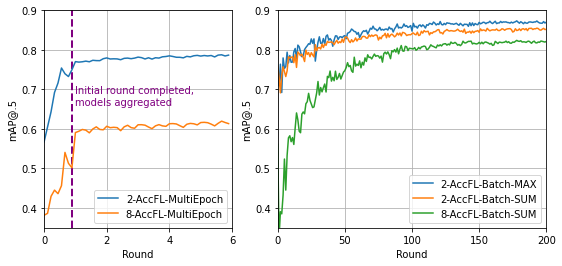

In [17]:
df1 = df.set_index('x-axis').sort_values('x-axis')
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.4, 2]}, figsize=(9,4))
df1.loc[df1['name'].isin(['2-AccFL-MultiEpoch', '8-AccFL-MultiEpoch'])].groupby('run')['map50'].plot(xlabel='Round', ylabel='mAP@.5', ax=ax1)
ax1.legend(loc='lower right')
ax1.grid(True)
ax1.vlines(x=(8/9), ymin=0.35, ymax=0.92, colors='purple', ls='--', lw=2)
ax1.text(x=(9/9), y=0.66, s="Initial round completed,\nmodels aggregated", color='purple')
ax1.set_xlim(0,6)
ax1.set_ylim(0.35,0.90)
df1.loc[df1['name'].isin(['2-AccFL-Batch-MAX', '8-AccFL-Batch-SUM', '2-AccFL-Batch-SUM'])].groupby('name')['map50'].plot(xlabel='Round', ylabel='mAP@.5', ax=ax2, legend=True)
ax2.grid(True)
ax2.set_xlim(0,200)
ax2.set_ylim(0.35,0.90)
plt.rc('axes', labelsize=13)
plt.rc('xtick', labelsize=13)
plt.rc('legend', fontsize=12)
plt.savefig('./figures/6.eps', dpi=1600, format='eps', figsize=(9,4))

Create MB graph, by calculating the usage in a seperate column.

In [18]:
def cal_usage(row):
    if row['name'] in accfl_approaches:
        if row['round'] == 0: # In initial round
            return (row['client']+1) * 14.017*2 # Upload and download of model between two devices in the chain
        base = 9*14.017*2 # Initial round base cost.
        if row['name'] == '2-AccFL-FedAvg': 
            return base + row['round']* 5.7*2*9 #FedAvg model is smaller due to frozen backbone that does not have to be transmitted
        if 'Batch' in row['name']: # Batched approach uses model + optimizer (5.241MB)
            return base + row['round']* (14.017+5.241)*2*9 
        return base + 5.7*2*9*(row['round']-1) + 5.7*2*(row['client']+1) # MultiEpoch with frozen backbone between clients.
    else: # traditional approaches
#         print(row)
        if row['name'] in ['2-2-SUM', '2-2-AVG', '2-2-MAX', '2-2-RND', '8-2-MAX', '8-2-RND']:
            return (row['round']+1)*14.017*2*9 # every round is 14.017MB upload AND download, for 9 devices.
        elif row['round'] <= 21: # The old approaches didn't communicate in the first 21 rounds, not needed now anymore, but i'll keep it for future usage
            return 14.017*2*9 
        else: # The old approaches didn't communicate in the first 21 rounds, not needed now anymore, but i'll keep it for future usage
            return (row['round']-20)*14.017*2*9

In [19]:
df_mb = df[['x-axis', 'round', 'client', 'map50', 'name']].copy()
df_mb['round'] = pd.to_numeric(df_mb["round"])
df_mb['MB'] = df.apply(lambda row: cal_usage(row), axis=1)
df_mb = df_mb[['name', 'x-axis', 'map50', 'MB']]
df_mb = df_mb.rename(columns={'x-axis': 'round'})
df_mb = df_mb.sort_values('round')

Sizing for the graph

In [20]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


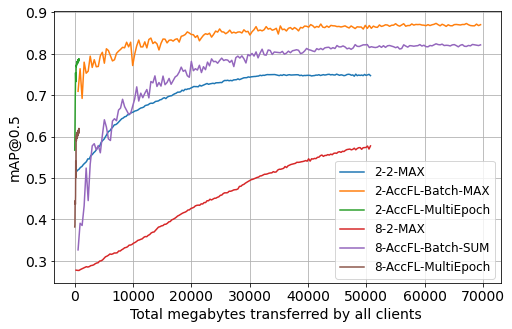

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
df_mb = df_mb.sort_values('round')
for id, group in df_mb[df_mb["name"].isin(['2-2-MAX','2-AccFL-Batch-MAX', '2-AccFL-MultiEpoch', '8-2-MAX', '8-AccFL-Batch-SUM', '8-AccFL-MultiEpoch'])].groupby('name'): 
    group.plot(x='MB', y='map50', ax=ax, label=id)
plt.grid(True)
ax.set_xlabel("Total megabytes transferred by all clients ")
ax.set_ylabel("mAP@0.5")
ax.legend(bbox_to_anchor=(0.9,0.12), loc="lower right",  bbox_transform=fig.transFigure)
plt.savefig('./figures/7.eps', dpi=1600, format='eps')